In [1]:
import os
import re, math
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

# now opart of tensorflow
# now opart of tensorflow
import efficientnet.tfkeras as efn

import cv2

In [2]:
# to remove some warnings

# TF2 way to reduce logging
# this remove also INFO, verify if needed
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
DEVICE = 'GPU'

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  2
Using strategy for multiple GPU
REPLICAS: 2


In [4]:
BASE_DIR = '/home/ubuntu/kaggle/diabetic'

TEST_IMAGES_DIR = os.path.join(BASE_DIR, 'test256')

TFREC_DIR = os.path.join(BASE_DIR, 'tfrec')

TEST_FILENAMES = tf.io.gfile.glob(os.path.join(TFREC_DIR,'test*.tfrec'))

NUM_CLASSES = 5

FOLDS = 5

In [5]:
imSize = 256
IMAGE_SIZE= [256,256]
BATCH_SIZE = 512*4

AUTO = tf.data.experimental.AUTOTUNE

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    # porto a 256x256
    # image = tf.image.resize(image, [imSize,imSize])
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'patient_id' : tf.io.FixedLenFeature([], tf.int64), 
        'side' : tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    patient_id = example['patient_id']
    side = example['side']
    
    return image, patient_id, side

def get_test_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.cache()
    dataset = dataset.map(read_unlabeled_tfrecord)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# count # of images in files.. (embedded in file name)
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [6]:
n_test_images =  count_data_items(TEST_FILENAMES)

n_test_images

53576

In [7]:
# funzione vettoriale di conversione 0 -> left, 1 -> right
def side_map(side):
    if side == 0:
        s_side = 'left'
    else:
        s_side = 'right'
    return s_side

v_side_map = np.vectorize(side_map)

In [8]:
# carico il modello dall'ultimo run
# per ora prendo fold0
# adding some data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  # introduced in TF 2.3
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = 256, ef = 0):
    inp = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # introdotta la data augmentation come parte del modello
    x = data_augmentation(inp)
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top = False)
    
    x = base(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = tf.keras.Model(inputs = inp,outputs = x)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0) 
    
    model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [9]:
# in questo modo itero una volta sull'intero test dataset
# ed estraggo tutti i nomi dei file delle immagini
# TODO poi batch per batch posso effettuare le predizioni

print('Test: reading TFREcords file...')
print("Examples of the test data:")


class_prob_predictions = np.zeros(shape = (FOLDS, n_test_images, NUM_CLASSES))

for fold in range(0,5):
    # ricarica i dati
    test_dataset = get_test_dataset(TEST_FILENAMES)
    
    print('Predictions using model fold ', fold)
    
    K.clear_session()
    with strategy.scope():
        model = build_model(ef = 4)

    model.load_weights('fold-%i.h5'%fold)
    
    batch_num = 0
    img_names = np.array([])
    class_predictions_fold = np.zeros(shape = (n_test_images, NUM_CLASSES))
    
    for image, patient_id, side in iter(test_dataset):
        # print('Working on batch num: ', batch_num)
    
        # predizione sul singolo batch
        preds_batch = model.predict(image.numpy())
        
        # devo costruire i nomi dei files
        s_patient_id = np.char.mod('%d', patient_id.numpy())
        name = np.char.add(s_patient_id, '_')
    
        # side devo trasformare 0 in left, 1 in right
        s_side = v_side_map(side.numpy())
    
        name = np.char.add(name, s_side)
    
        # salvo 
        img_names = np.append(img_names, name)
        
        start = batch_num * len(preds_batch)
        end = ((batch_num + 1) * len(preds_batch))
        class_predictions_fold[start:end] = preds_batch
        
        batch_num += 1
    
    # end of fold
    class_prob_predictions[fold] = class_predictions_fold

# alla fine    
# faccio la media sugli n folds
class_prob_predictions_avg = np.mean(class_prob_predictions, axis = 0)

classes_predicted = np.argmax(class_prob_predictions_avg, axis = 1)

# converto ad interi
classes_predicted = classes_predicted.astype('int64')

Test: reading TFREcords file...
Examples of the test data:
Predictions using model fold  0
Predictions using model fold  1
Predictions using model fold  2
Predictions using model fold  3
Predictions using model fold  4


In [10]:
len(img_names)

53576

In [11]:
len(classes_predicted)

53576

In [12]:
# ora devo combinare image name e class_predictions in un singolo file
submission = pd.DataFrame(dict(image=img_names, level=classes_predicted))

In [13]:
submission.tail(20)

,image,level
53556,16271_right,0
53557,19259_right,0
53558,8184_left,0
53559,33609_right,0
53560,43992_right,0
53561,38085_left,0
53562,4348_left,0
53563,5170_left,0
53564,17765_left,0
53565,33982_left,0


In [14]:
submission = submission.sort_values('image') 
submission.to_csv('sub_diabetic08.csv', index=False)

In [15]:
# kaggle submission
%env KAGGLE_USERNAME=luigisaetta
%env KAGGLE_KEY = 8052f0a7efb83795d3da6ef4eb47dc5c

! kaggle competitions submit -c diabetic-retinopathy-detection -f sub_diabetic08.csv -m "5 fold, old ef4, gaussian blur"

env: KAGGLE_USERNAME=luigisaetta
env: KAGGLE_KEY=8052f0a7efb83795d3da6ef4eb47dc5c
100%|█████████████████████████████████████████| 693k/693k [00:02<00:00, 251kB/s]
Successfully submitted to Diabetic Retinopathy Detection

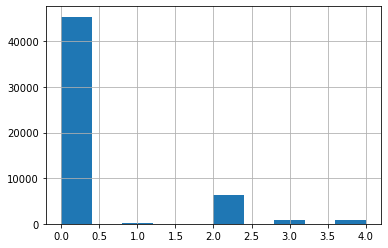

In [16]:
submission.level.hist();